Experiment for the paper "Identification of singleton mentions in Russian"
==============================================
Replication of CLLS-2016 paper (Ionov and Toldova 2016)
-------------------------------------

To reproduce this experiment you will need:
1. [RuCor corpus (from 2015-10-29)](http://rucoref.maimbava.net/files/rucoref_29.10.2015.zip)
2. [`scikit-learn`](http://scikit-learn.org/stable/install.html), [`unbalanced-dataset`](https://github.com/fmfn/UnbalancedDataset), [`matplotlib`](http://matplotlib.org/users/installing.html) Python modules
2. `anaphoralib` [Python module](https://github.com/max-ionov/rucoref)

Since `anaphoralib` is in an early stage of development, there is no way to install it yet, so in order to import it, you should `cd` to the folder with the module. Paths to the corpus should be updated accordingly.

In [2]:
%cd '/media/max/Extension/Projects/Coreference/'

/media/max/Extension/Projects/Coreference


In [3]:
from anaphoralib.corpora import rueval
from anaphoralib.tagsets import multeast
from anaphoralib.experiments.base import BaseClassifier
from anaphoralib import utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from unbalanced_dataset import SMOTE

import numpy as np

%matplotlib inline

In [4]:
lists_dir = 'CLLS-2016/wordlists'
texts_dir = 'Corpus-2015/Tokens.txt'
gs_dir = 'Corpus-2015/Groups.txt'

tagset = multeast

random_state = 42

Reading the texts from GS and matching them to actual texts
--------------

### Loading chains and GS

In [5]:
rucoref = rueval.RuCorefCorpus(multeast, rueval)

In [6]:
rucoref.load_texts(texts_dir)
rucoref.load_gs(gs_dir)

In [7]:
rucoref.find_groups()

In [8]:
rucoref.groups[0][:10]

[Во(Sp-a, 0),
 время своих прогулок(Ncnsan, 3),
 в(Sp-l, 24),
 окрестностях Симеиза(Ncfpln, 26),
 я(P-1-snn, 47),
 обратил(Vmis-sma-p, 49),
 внимание(Ncnsan, 57),
 на(Sp-a, 66),
 одинокую дачу(Ncfsan, 69),
 стоявшую(Vmps-sfa-ea, 84)]

In [9]:
rucoref.print_stats()

Number of texts: 181
Number of GS texts: 181
Number of chains in a corpus: 3638
Number of words in all chains: 16557


In [10]:
rucoref.create_indices()

### Loading special lists
Special lists load from the directory stored in `lists_dir`

In [11]:
import codecs

def load_list(filename):
    data = set()
    with codecs.open(filename, encoding='utf-8') as inp_file:
        for line in inp_file:
            data.add(line.strip('\r\n'))
    
    return data

In [12]:
import os

wordlists = {}

for filename in os.listdir(lists_dir):
    wordlists[filename.replace('.txt', '')] = load_list(os.path.join(lists_dir, filename))

In [13]:
print wordlists.keys()

['neg_pronouns', 'non-identity_sim', 'possessives', 'indef']


### Building indices and dictionaries

Building additional indices (of all words and all groups):

In [14]:
import collections

word_index = []
group_index = []

for i, text in enumerate(rucoref.texts):
    word_index.append(collections.defaultdict(set))
    group_index.append(collections.defaultdict(set))
    
    for word in text:
        word_index[-1]['_'.join(word.lemma)].add(word.offset)
    for group in rucoref.groups[i]:
        for g in group.iter_groups():
            group_index[-1]['_'.join(g.lemma)].add(g.offset)

In [15]:
print '\n'.join(group_index[0].keys()[:15])

спокойно
кой
другой_сторона_можжевелового_куст
линия
поднять
прежде
кругом
подставить
хотя
и
хоть
случиться
вышележащие
поддерживать
небольшой


### Creating a classifier

In [16]:
import re

class SingletonClassifier(BaseClassifier):
    def __init__(self):
        super(SingletonClassifier, self).__init__()
        
        self.feat_zones_ = ('struct', 'string', 'lists', 'synt')
        self.stats = {'str_matches_before', 'head_matches_before', 'n_adj', 'len_np', 'is_genitive'}
        self.stats.update('in_list_{}'.format(l) for l in wordlists)
        
        self.rx_lat = re.compile('[A-Za-z]')
        self.pronouns = {u"его", u"ее", u"её", u"ей", u"ему", u"ею", u"им", u"ими", u"их", u"которая", 
                u"которого", u"которое", u"которой", u"котором", u"которому", u"которую", u"которые", 
                u"который", u"которым", u"которыми", u"которых", u"него", u"нее", u"неё", u"ней", u"нем", 
                u"нём", u"нему", u"нею", u"ним", u"ними", u"них", u"он", u"она", u"они", u"оно", u"свое", 
                u"своё", u"своего", u"своей", u"своем", u"своём", u"своему", u"своею", u"свой", u"свои", 
                u"своим", u"своими", u"своих", u"свою", u"своя", u"себе", u"себя", u"собой", u"собою"}
        
        self.clear_stats()
        
    def get_feature_vector(self, corpus, group, i_text, save_feature_names=False):
        if save_feature_names:
            self.feature_names_ = []
            
        vctr = []
        
        group_lemma = '_'.join(group.lemma)
        group_occurrences = group_index[i_text][group_lemma] if group_lemma in group_index[i_text] else []

        head_index = group.head
        head_lemma = group.lemma[group.head]
        head_occurrences = word_index[i_text][head_lemma] if head_lemma in word_index[i_text] else []
        head_offset = group.head_offset

        group_words = group.words if group.type != 'word' else [group]

        str_matches_before = sum(1 for occ in group_occurrences if occ < group.offset)
        head_matches_before = sum(1 for occ in head_occurrences if occ < group.offset)
        
        adj_in_group = [word for word in group_words[:head_index+1] if tagset.pos_filters['adj'](word)]
        
        self.stats['str_matches_before'].append(str_matches_before)
        self.stats['head_matches_before'].append(head_matches_before)
        
        self.stats['n_adj'].append(len(adj_in_group))
        self.stats['len_np'].append(len(group_words))
        
        if 'string' in self.feat_zones_:
            vctr.append(('str_match_before=0', str_matches_before == 0))
            vctr.append(('head_match_before=0', head_matches_before == 0))
            
            #vctr.append(('uppercase', all(word.isupper() and len(word) > 1 for word in group.wordform)))
            #vctr.append(('capitalized', any(word[0].isupper() and len(group.wordform) > 1 for word in group.wordform[1:])))
            vctr.append(('latin', any(self.rx_lat.search(word) for word in group.wordform)))
            vctr.append(('is_proper_noun', corpus.tagset.pos_filters['properNoun'](group)))
            
            vctr.append(('is_animate', corpus.tagset.extract_feature('animate', group) == u'y'))
        vctr.append(('is_pronoun', group.wordform[0] in self.pronouns and len(group_words) == 1))
        
        i_word = corpus.words_index[i_text][group.offset]
        left_word = corpus.texts[i_text][i_word - 1] if i_word > 0 else None
        right_word = corpus.texts[i_text][i_word + len(group.wordform) + 1] \
                            if i_word + len(group.wordform) + 1 < len(corpus.texts[i_text]) else None
        
        if 'struct' in self.feat_zones_:
            #vctr.append(('conj', bool((left_word and corpus.tagset.pos_filters['conj'](left_word)) 
            #            or (right_word and corpus.tagset.pos_filters['conj'](right_word)))))
            
            vctr.append(('len_np==1', len(group.tags) == 1))
            vctr.append(('1<len_np<4', 1 < len(group.tags) < 4))
            vctr.append(('len_np>=4', 1 < len(group.tags) >= 4))
            
            vctr.append(('n_adj=0', len(adj_in_group) == 0))
            #vctr.append(('n_adj>1', len(adj_in_group) > 1))
            vctr.append(('n_adj>2', len(adj_in_group) > 2))
            
            vctr.append(('is_genitive', corpus.tagset.extract_feature('case', group) == u'g'))
            self.stats['is_genitive'].append(vctr[-1][1])
        
        sent_begin = left_word is None or left_word.tag == 'SENT'
        sent_end = right_word is None or right_word.tag == 'SENT'
        
        nomin = corpus.tagset.extract_feature('case', group) == u'n'
        accus = corpus.tagset.extract_feature('case', group) == u'a'
        
        if 'synt' in self.feat_zones_:
            vctr.append(('is_subject', nomin or sent_begin))
            #vctr.append(('is_object', accus or sent_end))
            
        if 'lists' in self.feat_zones_:
            for l in wordlists:
                feat_name = 'in_list_{}'.format(l)
                vctr.append((feat_name, any(lemma in wordlists[l] for lemma in group.lemma[:head_index+1])))
                self.stats[feat_name].append(vctr[-1][1])
        
        if save_feature_names:
            self.feature_names_ = [feat[0] for feat in vctr]
        
        return [feat[1] for feat in vctr]
    
    def prepare_data(self, corpus, random_state=42, test_size=0.3, feature_zones=None):
        if feature_zones:
            self.feat_zones_ = feature_zones
        
        self.groups = []
        self.x_data = []
        self.y_data = []
        
        self.stats['class'] = []

        self.cur_data_ = 'Singletons'
        self.class_names_ = ('non-singleton', 'singleton')
        
        save_features = True
    
        exceptions = {u'и', u'в', u'а', u'к', u'у', u'по', u'где', u'ведь', u'с'}
        for i_text, text in enumerate(corpus.texts):
            for i, mention in enumerate(corpus.mentions[i_text]):
                group = corpus.heads_index[i_text][mention.offset]
                if group.lemma[0] in exceptions and group.tags[0].startswith('N'):
                    continue
                    
                if i not in rucoref.gs_index[i_text]:
                    self.y_data.append(self.class_names_.index('singleton'))
                else:
                    self.y_data.append(self.class_names_.index('non-singleton'))

                self.x_data.append(self.get_feature_vector(corpus, group, i_text, save_features))
                self.groups.append(group)
                self.stats['class'].append(self.class_names_[self.y_data[-1]])
                save_features = False

                #pronoun_index = self.feature_names_.index('is_pronoun')
                #if self.x_data[-1][pronoun_index]:
                #    self.x_data.pop()
                #    self.y_data.pop()
                #    continue
                
                #del self.x_data[-1][pronoun_index]
            
        super(SingletonClassifier, self).prepare_data(corpus, random_state, test_size)
    
        #del self.feature_names_[pronoun_index]
        class_numbers = [sum(1 for item in self.y_data if item == cur_class) for cur_class in range(len(self.class_names_))]
        self.ratio = float(max(class_numbers) / float(min(class_numbers)))

### Training and testing

In [17]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state)

#### Baseline

In [18]:
def baseline_predict(data):
    y_pred = np.zeros(len(data))
    for i, row in enumerate(data):
        y_pred[i] = (row[0] == 1 and row[1] == 1)
    
    return y_pred

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


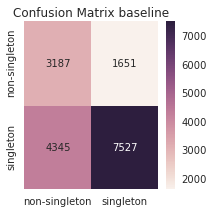

Report baseline:                precision    recall  f1-score   support

non-singleton      0.423     0.659     0.515      4838
    singleton      0.820     0.634     0.715     11872

  avg / total      0.705     0.641     0.657     16710



In [19]:
singleton_clf.test(y_pred=baseline_predict(singleton_clf.x_data_test), test_name='baseline')

#### String features

In [20]:
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string',))

In [21]:
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = SMOTE(ratio=singleton_clf.ratio, verbose=True, kind='borderline1', random_state=random_state)

singleton_clf.fit(clf, sampler)

Determining classes statistics... 2 classes detected: {0: 10936, 1: 28053}
Finding the 10 nearest neighbours...done!
Generated 27679 new samples ...


In [22]:
singleton_clf.print_stats()

Classifier <class 'sklearn.ensemble.forest.RandomForestClassifier'>: fitted
Data: Singletons (non-singleton, singleton)
Total:	55699 samples
	15774 non-singleton
	39925 singleton


In [23]:
len(singleton_clf.x_data_train)

38989

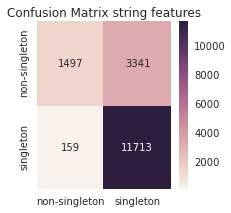

Report string features:                precision    recall  f1-score   support

non-singleton      0.904     0.309     0.461      4838
    singleton      0.778     0.987     0.870     11872

  avg / total      0.815     0.791     0.752     16710



In [24]:
singleton_clf.test(test_name='string features')

#### String + Struct features

Determining classes statistics... 2 classes detected: {0: 10936, 1: 28053}
Finding the 10 nearest neighbours...done!
Generated 27679 new samples ...


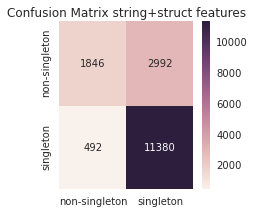

Report string+struct features:                precision    recall  f1-score   support

non-singleton      0.790     0.382     0.514      4838
    singleton      0.792     0.959     0.867     11872

  avg / total      0.791     0.792     0.765     16710



In [25]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=singleton_clf.ratio, verbose=True, kind='borderline1', random_state=random_state)

singleton_clf.fit(clf, sampler)
singleton_clf.test(test_name='string+struct features')

#### String + Struct + List features

Determining classes statistics... 2 classes detected: {0: 10936, 1: 28053}
Finding the 10 nearest neighbours...done!
Generated 27679 new samples ...


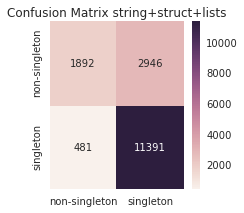

Report string+struct+lists:                precision    recall  f1-score   support

non-singleton      0.797     0.391     0.525      4838
    singleton      0.795     0.959     0.869     11872

  avg / total      0.795     0.795     0.770     16710



In [26]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=singleton_clf.ratio, verbose=True, kind='borderline1', random_state=random_state)

singleton_clf.fit(clf, sampler)
singleton_clf.test(test_name='string+struct+lists')

#### All features

Determining classes statistics... 2 classes detected: {0: 10936, 1: 28053}
Finding the 10 nearest neighbours...done!
Generated 27679 new samples ...


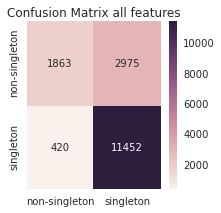

Report all features:                precision    recall  f1-score   support

non-singleton      0.816     0.385     0.523      4838
    singleton      0.794     0.965     0.871     11872

  avg / total      0.800     0.797     0.770     16710



In [27]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists', 'synt'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=singleton_clf.ratio, verbose=True, kind='borderline1', random_state=random_state)

singleton_clf.fit(clf, sampler)
singleton_clf.test(test_name='all features')

In [28]:
for i, feat_val in enumerate(singleton_clf.clf_.feature_importances_):
    print '{}: {:.4f}'.format(singleton_clf.feature_names_[i], feat_val)

str_match_before=0: 0.1212
head_match_before=0: 0.0827
latin: 0.0164
is_proper_noun: 0.1347
is_animate: 0.1158
is_pronoun: 0.2702
len_np==1: 0.0259
1<len_np<4: 0.0197
len_np>=4: 0.0033
n_adj=0: 0.0220
n_adj>2: 0.0002
is_genitive: 0.0129
is_subject: 0.0309
in_list_neg_pronouns: 0.0011
in_list_non-identity_sim: 0.0003
in_list_possessives: 0.1259
in_list_indef: 0.0167


In [29]:
import codecs

out_singletons = codecs.open('singletons.all.txt', 'w', encoding='utf-8')
out_non_singletons = codecs.open('non-singletons.all.txt', 'w', encoding='utf-8')
for i, item in enumerate(singleton_clf.groups_train):
    if singleton_clf.y_data_train[i] == 1:
        out_singletons.write(str(singleton_clf.groups_train[i]).decode('utf-8'))
        out_singletons.write('\n')
    else:
        out_non_singletons.write(str(singleton_clf.groups_train[i]).decode('utf-8'))
        out_non_singletons.write('\n')

In [30]:
out_fp = codecs.open('singletons.fp.txt', 'w', encoding='utf-8')
out_fn = codecs.open('singletons.fn.txt', 'w', encoding='utf-8')

y_pred = singleton_clf.clf_.predict(singleton_clf.x_data_test)
for i, item in enumerate(singleton_clf.groups_test):
    if singleton_clf.y_data_test[i] == 0 and y_pred[i] != singleton_clf.y_data_test[i]:
        out_fp.write(str(singleton_clf.groups_test[i]).decode('utf-8'))
        out_fp.write('\n')
    if singleton_clf.y_data_test[i] == 1 and y_pred[i] != singleton_clf.y_data_test[i]:
        out_fn.write(str(singleton_clf.groups_test[i]).decode('utf-8'))
        out_fn.write('\n')

### Calculating feature importances

In [31]:
regr = LogisticRegression(random_state=random_state)
sampler = SMOTE(ratio=singleton_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

singleton_clf.fit(regr, sampler)

In [32]:
for i, feat_name in enumerate(singleton_clf.feature_names_):
    print '{}: {:.4f}'.format(feat_name, regr.coef_[0,i])

str_match_before=0: 0.8355
head_match_before=0: 0.9925
latin: -2.2110
is_proper_noun: -1.5297
is_animate: -1.7239
is_pronoun: -5.4634
len_np==1: -0.8468
1<len_np<4: -0.2655
len_np>=4: 1.0582
n_adj=0: 1.4564
n_adj>2: -0.8750
is_genitive: 0.2545
is_subject: -0.3326
in_list_neg_pronouns: 2.3947
in_list_non-identity_sim: 0.5961
in_list_possessives: -3.0616
in_list_indef: 1.2615


## Additional actions

### Getting feature distributions

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [56]:
import anaphoralib.experiments.utils

In [34]:
singleton_clf.stats.keys()

['len_np',
 'str_matches_before',
 'in_list_possessives',
 'head_matches_before',
 'in_list_neg_pronouns',
 'n_adj',
 'in_list_non-identity_sim',
 'is_genitive',
 'in_list_indef',
 'class']

In [35]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists', 'synt'))

feature_distributions = {}
for feat_name in singleton_clf.stats:
    feature_distributions[feat_name] = {cls: [] for cls in singleton_clf.class_names_ + ('total',)}
    
    for i, elem in enumerate(singleton_clf.stats['class']):
        feature_distributions[feat_name][elem].append(singleton_clf.stats[feat_name][i])
        feature_distributions[feat_name]['total'].append(singleton_clf.stats[feat_name][i])

In [57]:
anaphoralib.experiments.utils.latexify()

In [39]:
def plot_feat_distribution(distribution, bins, class_names, x_label='Feature value', filename='plot.pdf'):
    bins = range(7)
    
    ax = plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel("Density")
    #ax.set_title("Distribution of feature")
    plt.tight_layout()
    format_axes(ax)
    
    normed = True
    
    true_hist = np.histogram(distribution[class_names[1]], bins, normed=normed)
    false_hist = np.histogram(distribution[class_names[0]], bins, normed=normed)
    
    w = 0.3
    
    true_x = [item for item in range(len(true_hist[0]))]
    false_x = [item+w for item in range(len(false_hist[0]))]
    
    ax.set_xticks([item + float(w) for item in true_x])
    ax.set_xticklabels(true_x)
    
    rects1 = plt.bar(false_x, false_hist[0], w, color='0.3')
    rects2 = plt.bar(true_x, true_hist[0], w, color='0.7')
    plt.legend((rects1, rects2), class_names, loc='upper right')
    
    plt.savefig("{}.pdf".format(filename))
    plt.show()
    plt.close()

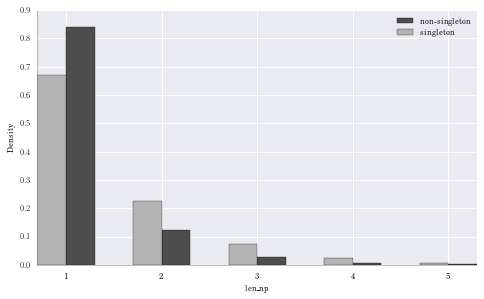

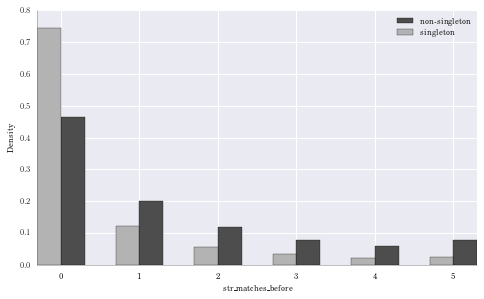

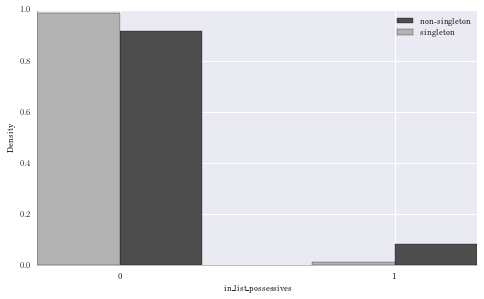

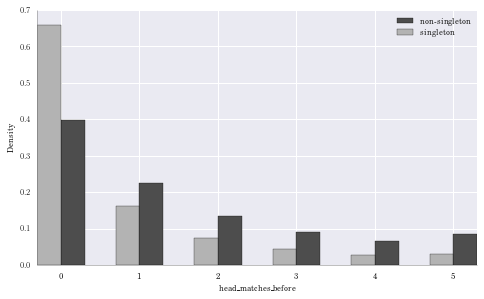

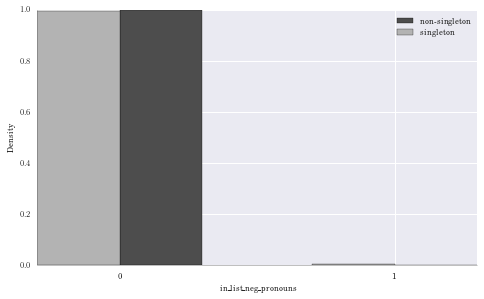

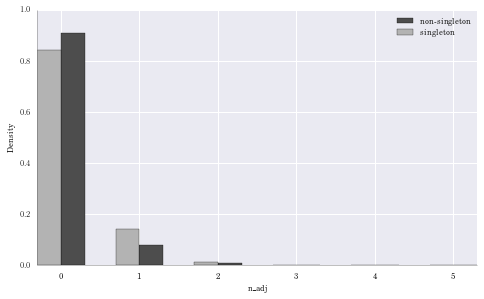

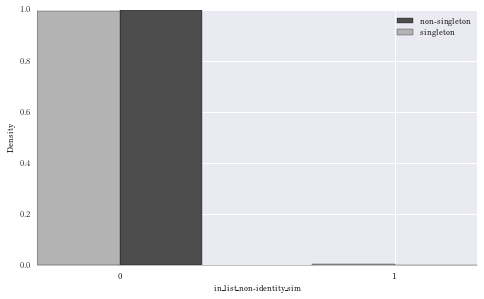

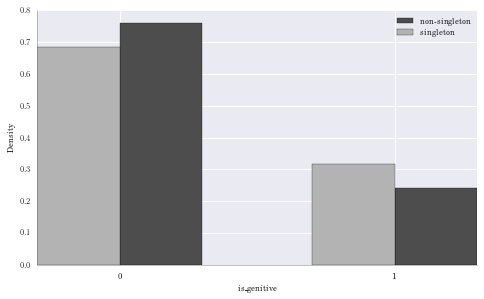

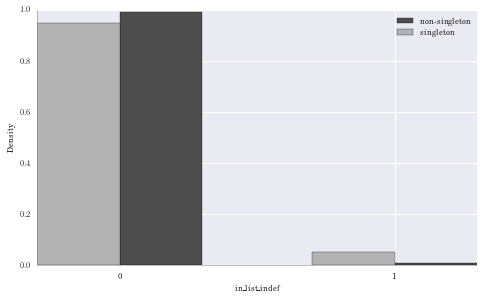

In [69]:
import os

anaphoralib.experiments.utils.latexify(columns=2)
for feat_name in feature_distributions:
    if feat_name == 'class':
        continue
    anaphoralib.experiments.utils.plot_feature_distribution(feature_distributions[feat_name], range(7),
                                                            singleton_clf.class_names_, 
                           x_label=feat_name.replace('_', '\\_'), filename=os.path.join('CLLS-2016', feat_name))

In [79]:
from sklearn.learning_curve import learning_curve
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import shuffle

In [42]:
singleton_clf = SingletonClassifier()
singleton_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists', 'synt'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)

In [86]:
shuffled_x_data, shuffled_y_data = shuffle(singleton_clf.x_data, singleton_clf.y_data, random_state=random_state)

train_sizes_abs, train_scores, test_scores = learning_curve(clf,
                                                            shuffled_x_data, 
                                                            shuffled_y_data,
                                                            cv=3,
                                                            scoring=make_scorer(f1_score, pos_label=0))

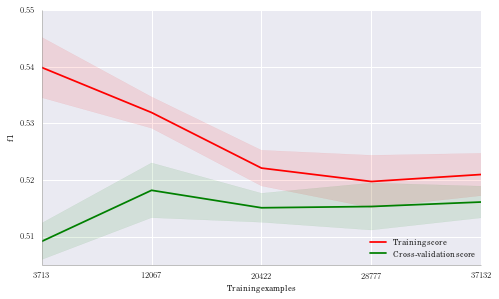

In [87]:
anaphoralib.experiments.utils.latexify(columns=2)
anaphoralib.experiments.utils.plot_learning_curve(train_sizes_abs, 
                                                  train_scores, test_scores, 
                                                  score_name='f1',
                                                  filename=os.path.join('CLLS-2016', 'learning_curve_plot'))